# Disclaimer: This notebook was run using CDMS kernel V04-00

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from qetpy.utils import lowpassfilter 
from qetpy import autocuts
import cdms
#from CDMSDataCatalog import CDMSDataCatalog
import scipy.optimize as optimize
import matplotlib as mpl
import pickle as pkl
import os, sys
import ROOT as rt
import seaborn as sns
import operator as op

/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-00/lib/python3.7/site-packages/datacat/model.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import OrderedDict, MutableMapping


Welcome to JupyROOT 6.22/00


In [12]:
series = {
    'target' : '23240112_235935',  
    'reference' : '23231226_001512'
}

rqbase = '/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/'
filePath = []

for i,key in enumerate(series.keys()):
    filePath.append('%s/Prompt_V04-15_P0.2.1_%s.root'%(rqbase,series[key]))
    print(key,' : ',filePath[i])
trace_length = 1.6 # uS

target  :  /sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged//Prompt_V04-15_P0.2.1_23240112_235935.root
reference  :  /sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged//Prompt_V04-15_P0.2.1_23231226_001512.root


In [3]:
# Get trees from RQ file

RQ=[]
for i,key in enumerate(series.keys()):
    RQ.append(uproot.open(filePath[i])['rqDir/zip2']) 

eventTree=[]
for i,key in enumerate(series.keys()):
    eventTree.append(uproot.open(filePath[i])['rqDir/eventTree']) 
print('Done!')



Done!


In [4]:
#Load RQs from processed files
channels=['PT','PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']

OFchiq={}
OFamps={}
OFdelay={}
OFamps0={}
OFnorms={}
OFbs={}
for i,key in enumerate(series.keys()):
    tc={}
    ta={}
    td={}
    ta0={}
    tn = {}
    tbs = {}
    for c in channels:
        tc[c]=(RQ[i].array(c+"OFchisq"))
        ta[c]=(RQ[i].array(c+"OFamps"))
        ta0[c]=(RQ[i].array(c+"OFamps0"))
        td[c]=(RQ[i].array(c+"OFdelay"))
        if(c!='PT'):
            tn[c] = (RQ[i].array(c+"norm"))
            tbs[c] = (RQ[i].array(c+"bs"))
    OFchiq[series[key]]=tc
    OFamps[series[key]]=ta
    OFamps0[series[key]]=ta0
    OFdelay[series[key]]=td
    OFnorms[series[key]]=tn
    OFbs[series[key]]=tbs
    
        
print('Done!')

Done!


In [5]:
# Get event info from processed files

TriggerTime=[]
TriggerType=[]
EventNumber=[]
TrigDet=[]
TriggerMask=[]
EventTime=[]
for i,key in enumerate(series.keys()):
    TriggerTime.append(eventTree[i].array("TriggerTime"))
    TriggerType.append(eventTree[i].array("TriggerType"))
    EventNumber.append(eventTree[i].array("EventNumber"))
    TrigDet.append(eventTree[i].array("TriggerDetectorNum"))
    TriggerMask.append(eventTree[i].array("TriggerMask"))
    EventTime.append(eventTree[i].array("EventTime"))
print('Done!')

Done!


In [6]:
# Get noise info from BatNoise file
noisebase = '/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Noise/'

noisefile = []
for i,key in enumerate(series.keys()):
    path = '%s/Prompt_V04-15_P0.2.1_Filter_%s.root'%(noisebase,series[key])
    file = rt.TFile.Open(path)
    if(not file):
        print('Couldnt open %s'%(path))
    noisefile.append(file)    

print('Files loaded...')

template_hist = {}
for i, key in enumerate(series.keys()):
    th = {}
    for c in channels:
        temp = noisefile[i].Get('zip2/%sTemplateTime'%(c))
        if(not temp):
            print('NULL for %s : %s'%(key,c))
        th[c] = temp
    template_hist[key] = th
print('Templates laoded as histograms...')

template = {}
for i, key in enumerate(series.keys()):
    tarr = {}
    for c in channels:
        bincenter = []
        bincontent = []
        #bincontent = [temp.GetBinContent(j) for j in temp.GetNbinsX()]
        temp = template_hist[key][c]
        for j in range(temp.GetNbinsX()):
            bincenter.append(temp.GetBinCenter(j))
            bincontent.append(temp.GetBinContent(j))
        tarr[c] = bincontent
    template[key] = tarr

print('Templates loaded as dict...')

Files loaded...
Templates laoded as histograms...
Templates loaded as dict...


In [7]:
can = rt.TCanvas()

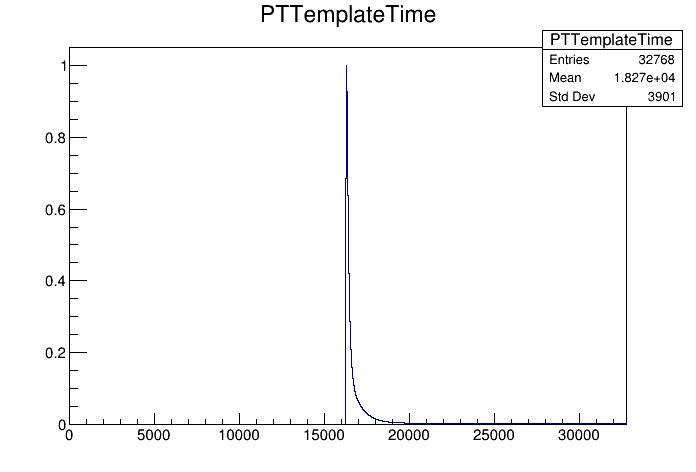

In [8]:
template_hist['target']['PT'].Draw()
can.Draw()

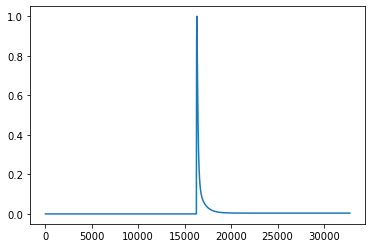

In [18]:
plt.plot(template['target']['PT'])
plt.show()

In [9]:
OFamps[series['target']]['PT']

array([-9.99999000e+05,  2.04307270e-07,  1.02256168e-06, ...,
        3.95293392e-05,  3.91326683e-05, -9.99999000e+05])

In [ ]:
mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.5e-6) & (OFchi2[series[key]][det][chan] > 1e5) & (TrigDet[idx] == 2)
x = OFamps[series[key]][det][chan][mask]*1e6
y = OFchiq[series[key]][det][chan][mask]

In [68]:
cc = ['PA','PB','PC','PD','PE','PF']
ss = ['S1','S2']
det = 'Z2'
time_diff = {}
for idx, key in enumerate(list(series.keys())):
    tt = {}
    for c in cc:
        mask = (TriggerType[idx] == 1) & (OFamps[series[key]]['PAS1'] > 0.5e-6) & (OFchiq[series[key]]['PAS1'] > 1e5) & (TrigDet[idx] == 2)
        delayS1 = (((OFdelay[series[key]][c+'S1'][mask])*1e6)/trace_length)
        delayS2 = (((OFdelay[series[key]][c+'S2'][mask])*1e6)/trace_length)
        diff = delayS2 - delayS1
        tt[c] = diff.tolist()
    time_diff[key] = tt
print('done')

done


In [39]:
for c in cc:
    print(c,' : ',len(time_diff['target'][c]))
len()

PA  :  86695
PB  :  86695
PC  :  86695
PD  :  86695
PE  :  86695
PF  :  86695


TypeError: len() takes exactly one argument (0 given)

In [85]:
def plot(td,k,limits):
    plot_data = td

    # sort keys and values together
    sorted_keys, sorted_vals = zip(*sorted(plot_data.items(), key=op.itemgetter(1)))

    # almost verbatim from question
    sns.set(context='notebook', style='whitegrid')
    #sns.axlabel(xlabel="Groups", ylabel="Y-Axis", fontsize=16)
    sns.boxplot(data=sorted_vals, width=.18)
    #sns.swarmplot(data=sorted_vals, size=6, edgecolor="black", linewidth=.9)

    # category labels
    plt.title('%s : %s'%(k,series[k]))
    plt.xticks(plt.xticks()[0], sorted_keys)
    plt.xlabel('Channel')
    plt.ylim(limits[0],limits[1])
    plt.ylabel('S2-S1 time bin difference')
    plt.show()

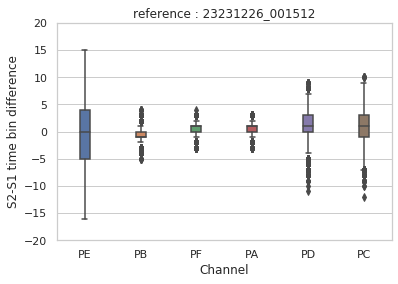

In [86]:
key = 'reference'
limits = [-20,20]
plot(time_diff[key],key,limits)

In [42]:
time_diff['target']

{'PA': array([144., 143., 144., ..., 144., 144., 144.]),
 'PB': array([143., 142., 143., ..., 142., 142., 142.]),
 'PC': array([144., 145., 140., ..., 143., 143., 142.]),
 'PD': array([144., 145., 140., ..., 143., 143., 142.]),
 'PE': array([143., 137., 149., ..., 146., 146., 148.]),
 'PF': array([144., 143., 143., ..., 144., 143., 144.])}

In [43]:
def plot_hist(data,chan,k):
    hname = 'h_%s_%s'%(k,chan)
    binmin = np.min(data)
    binmax = np.max(data)
    bins = int((binmax- binmin)+20)
    hist = rt.TH1F(hname,hname,bins,(binmin-10),(binmax+10))
    for i in data:
        hist.Fill(i)
    return hist
    

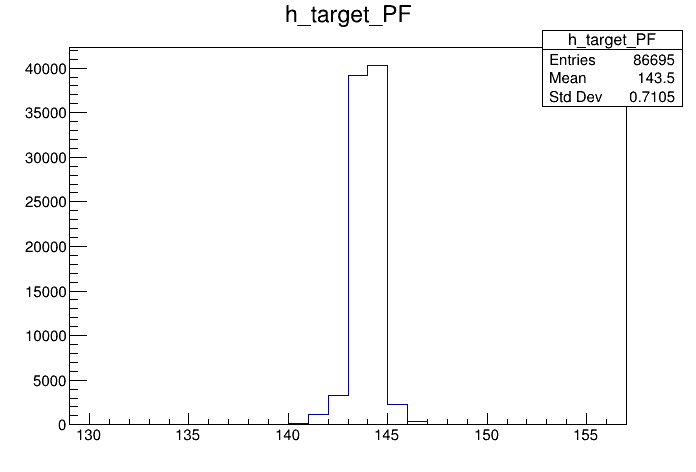

In [58]:
idx = 0
key = list(series.keys())[idx]
c = 'PF'
h = plot_hist(time_diff[key][c],c,key)
can = rt.TCanvas()
h.Draw()
can.SetLogy(0)
can.Draw()

In [59]:
for idx, key in enumerate(list(series.keys())):
    print('Series : ',series[key])
    for c in cc:
        mean = np.mean(time_diff[key][c])
        std = np.std(time_diff[key][c])
        print('\t time bin diff mean : std  = %s : %0.2f : %0.2f'%(c,mean,std))

Series :  23240112_235935
	 time bin diff mean : std  = PA : 143.47 : 0.75
	 time bin diff mean : std  = PB : 142.58 : 0.92
	 time bin diff mean : std  = PC : 143.70 : 2.72
	 time bin diff mean : std  = PD : 143.79 : 2.59
	 time bin diff mean : std  = PE : 142.37 : 5.37
	 time bin diff mean : std  = PF : 143.46 : 0.71
Series :  23231226_001512
	 time bin diff mean : std  = PA : 0.57 : 0.86
	 time bin diff mean : std  = PB : -0.52 : 0.84
	 time bin diff mean : std  = PC : 1.18 : 2.83
	 time bin diff mean : std  = PD : 1.14 : 2.71
	 time bin diff mean : std  = PE : -0.14 : 5.31
	 time bin diff mean : std  = PF : 0.57 : 0.58


In [ ]:
h_delay = []
h_psum = []
for i, key in enumerate(series.keys()):
    hname = 'h_pt_%d'%(i)
    temp_pt = rt.TH1F(hname,hname,180,2,20)
    hname = 'h_psum_%d'%(i)
    temp_psum = rt.TH1F(hname,hname,180,2,20)
    idx = i
    chan = 'PT'
   
    mask = (TriggerType[idx] == 1) & (OFamps[series[key]][chan] > 0.5e-6) & (TrigDet[idx] == 2)
    x = OFamps[series[key]][chan][mask]*1e6
    y = OFchiq[series[key]][chan][mask]
    for j in range(len(x)):
        if((x[j] > 2.0) & (x[j] < 20.0) & (y[j] < 1e6)):
            pt = x[j]
            psum = 0.
            for c in channels:
                if(c == 'PT'):
                    continue
                psum += (OFamps[series[key]][c][mask][j]*1e6)
            temp_pt.Fill(pt)

            temp_psum.Fill(psum)
    h_pt.append(temp_pt)
    h_psum.append(temp_psum)
    print('%s done'%(key))
        


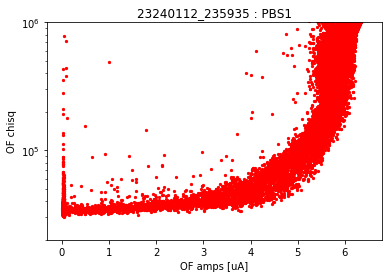

In [11]:
# Event selection
#Selecting saturated events
chan = 'PBS1'
idx = 0
key = list(series.keys())[idx]
mask = (TriggerType[idx] == 1) & (OFamps[series[key]][chan] > 0.) & (TrigDet[idx] == 2)
x = OFamps[series[key]][chan][mask]*1e6
y = OFchiq[series[key]][chan][mask]
plt.scatter(x,y,s=5 ,color='r')

# plt.vlines(1.5, 0.6e6, 3e6)
# plt.vlines(2.0, 0.6e6, 3e6)
# plt.hlines(0.6e6, 1.5, 2.0)
# plt.hlines(3e6, 1.5, 2.0)

#plt.xlim(0,20)
plt.ylim(2e4,1e6)


plt.yscale("log")
plt.xlabel("OF amps [uA]")
plt.ylabel("OF chisq")
plt.title(series[key]+ ' : ' + chan)
#plt.savefig("./plots/reverse_cal/OF_chi2_%s_scatter.png"%(c))
plt.show()


In [9]:
h_pt = []
h_psum = []
for i, key in enumerate(series.keys()):
    hname = 'h_pt_%d'%(i)
    temp_pt = rt.TH1F(hname,hname,180,2,20)
    hname = 'h_psum_%d'%(i)
    temp_psum = rt.TH1F(hname,hname,180,2,20)
    idx = i
    chan = 'PT'
   
    mask = (TriggerType[idx] == 1) & (OFamps[series[key]][chan] > 0.) & (TrigDet[idx] == 2)
    x = OFamps[series[key]][chan][mask]*1e6
    y = OFchiq[series[key]][chan][mask]
    for j in range(len(x)):
        if((x[j] > 2.0) & (x[j] < 20.0) & (y[j] < 1e6)):
            pt = x[j]
            psum = 0.
            for c in channels:
                if(c == 'PT'):
                    continue
                psum += (OFamps[series[key]][c][mask][j]*1e6)
            temp_pt.Fill(pt)

            temp_psum.Fill(psum)
    h_pt.append(temp_pt)
    h_psum.append(temp_psum)
    print('%s done'%(key))
        


target done
reference done


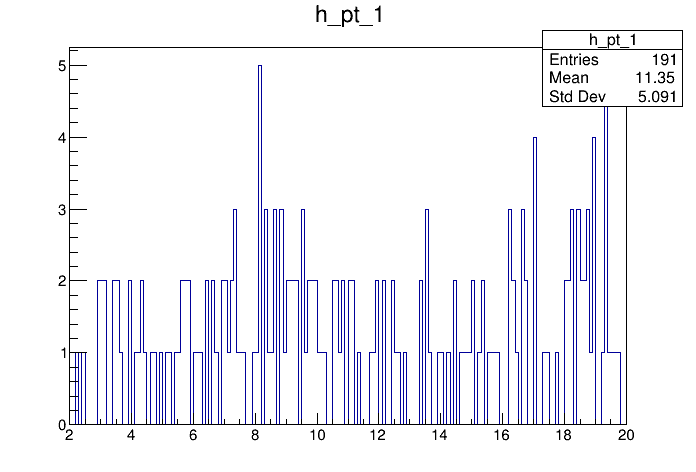

In [50]:
h_pt[1].Draw()
can.Draw()

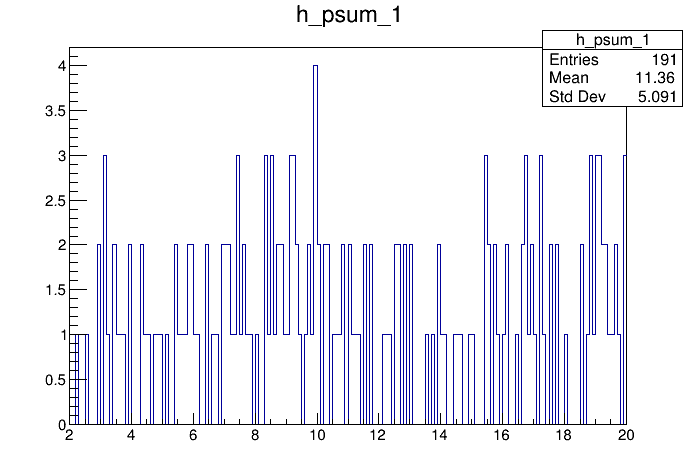

In [51]:
h_psum[1].Draw()
can.Draw()

In [10]:
Rshunt = 5.0e-3 # shunt resistance
Rfb = 5000.0 # feedback resistance
ADCperVolt = 65536.0/8.0 # the number of ADC bins per V for the readout
LoopRatio = 2.4 # SQUID turn ratio 
low_pass_filter = False
high_cutoff, fs, order = 100000, 625000, 2
trace_length = 1.6 # uS
bins = 32768
rawfilepath='/sdf/group/supercdms/data/CDMS/CUTE/R37/Raw/'

In [11]:
#Load detector settings
dsettings={}
for i,key in enumerate(series.keys()):
    dsettings[series[key]]=cdms.rawio.IO.getDetectorSettings(rawfilepath,series[key])

The file is: /sdf/group/supercdms/data/CDMS/CUTE/R37/Raw//23240112_235935/23240112_235935_F0001.mid.gz

Opened raw midas file: /sdf/group/supercdms/data/CDMS/CUTE/R37/Raw//23240112_235935/23240112_235935_F0001.mid.gz
INFO in DetectorConfigData: list of available detectors = 2
The file is: /sdf/group/supercdms/data/CDMS/CUTE/R37/Raw//23231226_001512/23231226_001512_F0001.mid.gz

Opened raw midas file: /sdf/group/supercdms/data/CDMS/CUTE/R37/Raw//23231226_001512/23231226_001512_F0001.mid.gz
INFO in DetectorConfigData: list of available detectors = 1, 2, 3, 4, 5, 6


In [12]:
#c = 'PAS2'
data = {}
raw_data = {}
det = 'Z2'
event_number = {}
adc2ua = {}
for idx, key in enumerate(series.keys()):
#     idx = 1
#     key = list(series.keys())[idx]
    c = 'PT'
    mask = (TriggerType[idx] == 1) & (OFamps[series[key]][c] > 0.) & (TrigDet[idx] == 2)
    cut = mask & (OFamps[series[key]][c] > 2e-6) & (OFamps[series[key]][c] < 20e-6)
    #event_number[c] = EventNumber[0][cut]
    t_rd = {}
    t_d = {}
    
    event_number[key] = EventNumber[idx][cut][:10]
    for c in channels:
        if(c=='PT'):
            continue
        #event_number[c] = EventNumber[idx][cut][:10]
        if os.path.exists('./rawdata/%s_%s_selected_events.pkl'%(series[key],c)):
            t_rd[c] = pkl.load(open('./rawdata/%s_%s_selected_events.pkl'%(series[key],c), "rb"))
            print('pkl file loaded for %s'%(c))
        else:
            print('No pickle file available. Loading traces... ')
            
            t_rd[c] = cdms.rawio.IO.getRawEvents(rawfilepath,'/'+series[key],outputFormat = 2, eventNumbers=(event_number[key]).astype(int).tolist(), 
                                                   channelList=[c], detectorList=[2])
            pkl.dump(t_rd[c], open('./rawdata/%s_%s_selected_events.pkl'%(series[key],c), "wb"))
            print('pkl file loaded for %s'%(c))
    raw_data[key] = t_rd
    print('Raw traces [ADC] loaded...')
    print('Now converting into amps...')
    t_adc2uA = {}
    for c in channels:
        if(c=='PT'):
            continue
        temp = []
        DriverGain = dsettings[series[key]][det][c]['driverGain']*4.0 #Apply Driver Gain Correction
        conv2Amps = 1/(Rfb*DriverGain*LoopRatio*ADCperVolt) #Convert detector parameters to amplitude for trace
        t_adc2uA[c] = conv2Amps
        for i in range(len(t_rd[c])):
            temp.append(((t_rd[c][i])[det][c])*conv2Amps)
        t_d[c] = temp
    data[key] = t_d
    adc2ua[key] = t_adc2uA
    
    print('-------- %s : Traces coverted to Amps for channel -------------'%(key))



/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23240112_235935_PAS1_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23240112_235935_PBS1_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23240112_235935_PCS1_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23240112_235935_PDS1_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/pytho

pkl file loaded for PAS1
pkl file loaded for PBS1
pkl file loaded for PCS1
pkl file loaded for PDS1
pkl file loaded for PES1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23240112_235935_PFS1_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23240112_235935_PAS2_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23240112_235935_PBS2_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23240112_235935_PCS2_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/pytho

pkl file loaded for PFS1
pkl file loaded for PAS2
pkl file loaded for PBS2
pkl file loaded for PCS2
pkl file loaded for PDS2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23240112_235935_PES2_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23240112_235935_PFS2_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231226_001512_PAS1_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231226_001512_PBS1_selected_events.pkl'>


pkl file loaded for PES2
pkl file loaded for PFS2
Raw traces [ADC] loaded...
Now converting into amps...
-------- target : Traces coverted to Amps for channel -------------
pkl file loaded for PAS1
pkl file loaded for PBS1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231226_001512_PCS1_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231226_001512_PDS1_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231226_001512_PES1_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231226_001512_PFS1_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/pytho

pkl file loaded for PCS1
pkl file loaded for PDS1
pkl file loaded for PES1
pkl file loaded for PFS1
pkl file loaded for PAS2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231226_001512_PBS2_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231226_001512_PCS2_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231226_001512_PDS2_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231226_001512_PES2_selected_events.pkl'>
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/pytho

pkl file loaded for PBS2
pkl file loaded for PCS2
pkl file loaded for PDS2
pkl file loaded for PES2
pkl file loaded for PFS2
Raw traces [ADC] loaded...
Now converting into amps...
-------- reference : Traces coverted to Amps for channel -------------


In [ ]:
eid = 0
idx = 1
key = list(series.keys())[idx]
plt.figure()
for c in channels:
    if(c == 'PT'):
        continue
    plt.plot(data[key][c][eid],label=c)
plt.legend()
plt.xlim(15800,16100)
plt.show()

In [13]:
event_number#['target']

{'target': array([11339., 11508., 20028., 20241., 20244., 20345., 20409., 20411.,
        20544., 20561.]),
 'reference': array([34639., 44379., 44507., 54072., 54778., 72641., 74605., 80032.,
        80808., 81733.])}

In [14]:
proc_of = {}
proc_bs = {}
proc_delay = {}

for idx, key in enumerate(series.keys()):
    t_of = []
    t_bs = []
    t_delay = []
    for enum in event_number[key]:
        tt_of = {}
        tt_bs = {}
        tt_delay = {}
        for c in channels:
            if(c != 'PT'):
                tt_bs[c] = ((OFbs[series[key]][c][EventNumber[idx] == enum]))
            tt_of[c] = ((OFamps[series[key]][c][EventNumber[idx] == enum]))
            
            tt_delay[c] = ((OFdelay[series[key]][c][EventNumber[idx] == enum]))
        t_of.append(tt_of)
        t_bs.append(tt_bs)
        t_delay.append(tt_delay)
    proc_of[key] = t_of
    proc_bs[key] = t_bs
    proc_delay[key] = t_delay
print('done')

done


In [15]:
proc_delay['target'][0]

{'PT': array([-0.000344]),
 'PAS1': array([-0.0005744]),
 'PBS1': array([-0.000576]),
 'PCS1': array([-0.000568]),
 'PDS1': array([-0.000576]),
 'PES1': array([-0.0005568]),
 'PFS1': array([-0.0005696]),
 'PAS2': array([-0.0003488]),
 'PBS2': array([-0.0003488]),
 'PCS2': array([-0.0003328]),
 'PDS2': array([-0.0003392]),
 'PES2': array([-0.0003472]),
 'PFS2': array([-0.0003424])}

In [112]:


idx = 0
key = list(series.keys())[idx]
c = 'PAS1'
(data[key][c][0])
proc_bs['target'][0][c][0]
adc2ua[key][c]
#adc2uA[key][c]
#event_number['target']

3.178914388020833e-10

In [16]:
# compute traces with pedestal subtracted

data_ped_sub = {}
for idx, key in enumerate(series.keys()):
    t = {}
    for c in channels:
        if(c == 'PT'):
            continue
        tt = []
        for i in range(len(event_number[key])):
            pedestal = proc_bs[key][i][c][0] * adc2ua[key][c]
            #ttt = data[key][c][i] - pedestal
            tt.append(data[key][c][i] - pedestal)
        t[c] = tt
    data_ped_sub[key] = t
print('done')


done


In [174]:
len(data_ped_sub['target']['PAS1'][0] + data_ped_sub['target']['PBS1'][0])

32768

# CHECK HERE
# compte PT

In [23]:
data_ped_sub['target']['PAS1'] # per series, per channel, per event : nparray
# data_ped_sub['target']['PT'][0]

[array([ 1.39410562e-08, -1.88017620e-08,  2.12525593e-08, ...,
        -1.31773290e-09, -3.22508153e-09,  1.83915363e-08]),
 array([ 2.20907142e-08, -2.17783044e-08,  3.19453488e-08, ...,
         7.14981658e-09, -1.75114371e-09,  2.20907142e-08]),
 array([ 1.24648851e-08,  1.34185594e-08, -2.79390396e-09, ...,
         1.27827765e-08,  2.61025050e-09, -4.06546972e-09]),
 array([ 2.42040487e-09,  1.95164798e-10, -2.20572359e-08, ...,
         1.14883911e-09, -1.12489270e-08, -2.01498873e-08]),
 array([-3.17968790e-08,  2.92382772e-08, -3.81547078e-08, ...,
        -4.67377766e-08,  1.89961350e-09, -5.11882568e-08]),
 array([ 2.33253706e-09,  1.37886274e-09, -2.10594450e-10, ...,
        -3.23176298e-08,  2.23596977e-08, -2.65955839e-08]),
 array([ 2.08086725e-08,  1.31792780e-08,  8.09301497e-09, ...,
        -2.52855861e-08,  3.16169814e-08, -1.44772772e-08]),
 array([ 1.30308772e-07,  1.63369482e-07,  1.23315161e-07, ...,
        -1.67555506e-07, -2.12378199e-07, -1.68509180e-07]),


In [24]:
# Add trace for PT (sum up all channel)

for idx, key in enumerate(series.keys()):
    
    tt = []
    for i in range(len(event_number[key])):
        t = np.zeros(bins)
        for c in channels:
            if(c == 'PT'):
                continue
            t += data_ped_sub[key][c][i]
        tt.append(t)
    
    data_ped_sub[key]['PT'] = tt
print('done')

done


In [70]:
data_ped_sub['reference']['PT'][0]

array([ 1.26898413e-07, -1.74780562e-07,  3.31204386e-08, ...,
        6.41755777e-09, -1.42453858e-08, -7.05121704e-08])

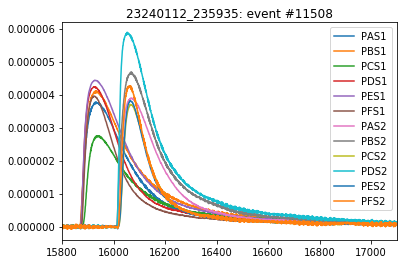

In [82]:
ttext = {
    'target' : series['target'],
    'reference' : series['reference'] 
}
eid = 1
idx = 0
key = list(series.keys())[idx]
plt.figure()
for c in channels:
    if(c == 'PT'):
        continue
    plt.plot(data_ped_sub[key][c][eid],label=c)
plt.legend()
plt.title(series[key]+': event #%d'%(event_number[key][eid]))

#plt.xlim(15800,16100)
plt.xlim(15800,17100)
plt.show()

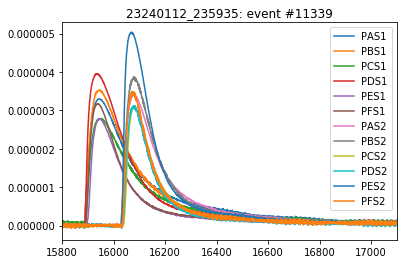

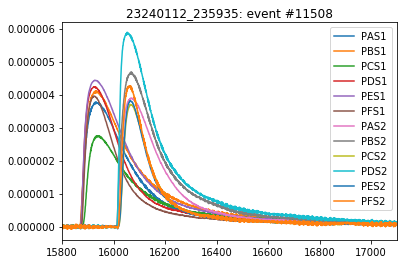

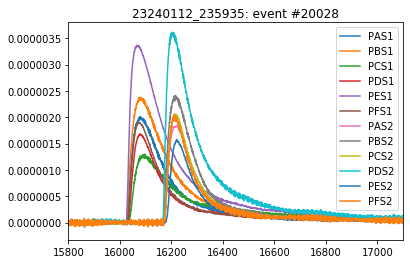

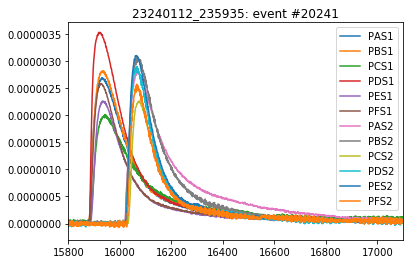

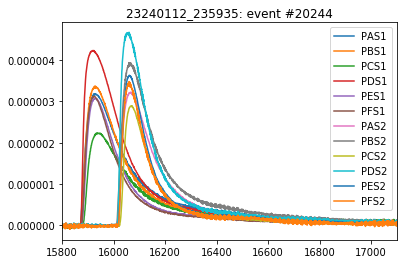

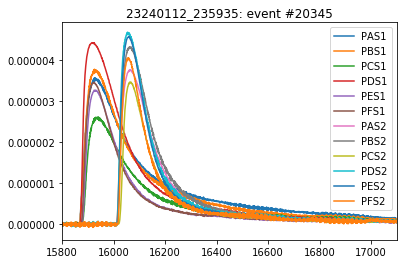

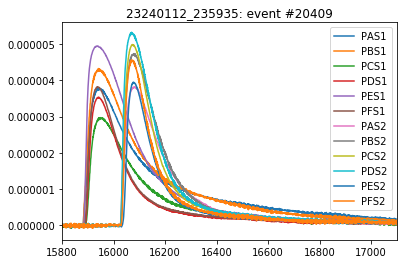

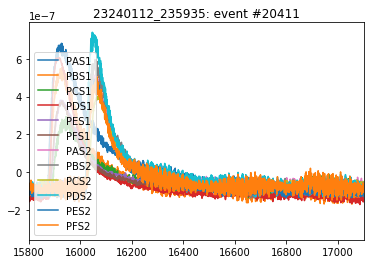

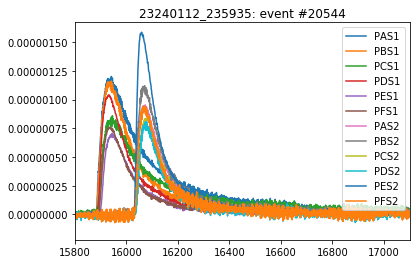

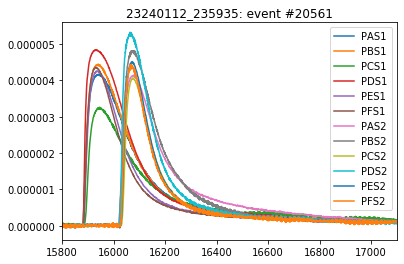

In [83]:
ttext = {
    'target' : series['target'],
    'reference' : series['reference'] 
}
idx = 0
key = list(series.keys())[idx]
plt.figure()
for eid in range(10):


    for c in channels:
        if(c == 'PT'):
            continue
        plt.plot(data_ped_sub[key][c][eid],label=c)
    plt.legend()
    plt.title(series[key]+': event #%d'%(event_number[key][eid]))

    #plt.xlim(15800,16100)
    plt.xlim(15800,17100)
    plt.show()

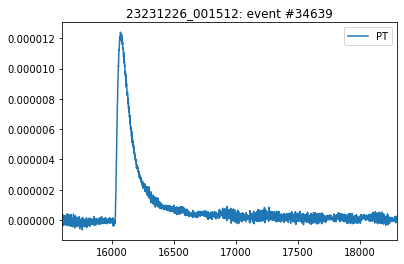

In [80]:
plt.figure()
#template_ss['target']['PAS1'][0]
plt.plot(data_ped_sub[key]['PT'][eid],label='PT')
plt.legend()
plt.title(series[key]+': event #%d'%(event_number[key][eid]))
# plt.plot((template_ss['target']['PAS1'][0])/np.max(template_ss['target']['PAS1'][0]))
# plt.plot(template['target']['PAS1'])
plt.xlim(15600,18300)
plt.show()

In [48]:
proc_delay[key][0]

{'PT': array([-0.0003488]),
 'PAS1': array([-0.0003472]),
 'PBS1': array([-0.0003488]),
 'PCS1': array([-0.0003296]),
 'PDS1': array([-0.0003536]),
 'PES1': array([-0.0003328]),
 'PFS1': array([-0.000344]),
 'PAS2': array([-0.0003488]),
 'PBS2': array([-0.000352]),
 'PCS2': array([-0.0003296]),
 'PDS2': array([-0.0003552]),
 'PES2': array([-0.0003488]),
 'PFS2': array([-0.000344])}

In [90]:
cc = ['PA','PB','PC','PD','PE','PF']
ss = ['S1','S2']
key='target'
time_diff = {}
for eid in range(10):
    print('%d : %d'%(eid,event_number[key][eid]))
    
    for c in cc:
        diff = ((proc_delay[key][eid][c+ss[1]] - proc_delay[key][eid][c+ss[0]]) *1e6)/trace_length
        print('\t %s (S2-S1) : %0.1f'%(c,diff))
        
for c in cc:
    t = []
    for eid in range(10):
        diff = ((proc_delay[key][eid][c+ss[1]] - proc_delay[key][eid][c+ss[0]]) *1e6)/trace_length
        t.append(diff[0])
    time_diff[c] = t

0 : 11339
	 PA (S2-S1) : 141.0
	 PB (S2-S1) : 142.0
	 PC (S2-S1) : 147.0
	 PD (S2-S1) : 148.0
	 PE (S2-S1) : 131.0
	 PF (S2-S1) : 142.0
1 : 11508
	 PA (S2-S1) : 142.0
	 PB (S2-S1) : 140.0
	 PC (S2-S1) : 139.0
	 PD (S2-S1) : 139.0
	 PE (S2-S1) : 151.0
	 PF (S2-S1) : 143.0
2 : 20028
	 PA (S2-S1) : 143.0
	 PB (S2-S1) : 143.0
	 PC (S2-S1) : 134.0
	 PD (S2-S1) : 132.0
	 PE (S2-S1) : 157.0
	 PF (S2-S1) : 142.0
3 : 20241
	 PA (S2-S1) : 139.0
	 PB (S2-S1) : 140.0
	 PC (S2-S1) : 145.0
	 PD (S2-S1) : 144.0
	 PE (S2-S1) : 135.0
	 PF (S2-S1) : 144.0
4 : 20244
	 PA (S2-S1) : 142.0
	 PB (S2-S1) : 139.0
	 PC (S2-S1) : 142.0
	 PD (S2-S1) : 143.0
	 PE (S2-S1) : 140.0
	 PF (S2-S1) : 143.0
5 : 20345
	 PA (S2-S1) : 141.0
	 PB (S2-S1) : 140.0
	 PC (S2-S1) : 141.0
	 PD (S2-S1) : 144.0
	 PE (S2-S1) : 135.0
	 PF (S2-S1) : 140.0
6 : 20409
	 PA (S2-S1) : 142.0
	 PB (S2-S1) : 143.0
	 PC (S2-S1) : 133.0
	 PD (S2-S1) : 134.0
	 PE (S2-S1) : 154.0
	 PF (S2-S1) : 141.0
7 : 20411
	 PA (S2-S1) : 146.0
	 PB (S2-S1) : 14

In [87]:
import seaborn

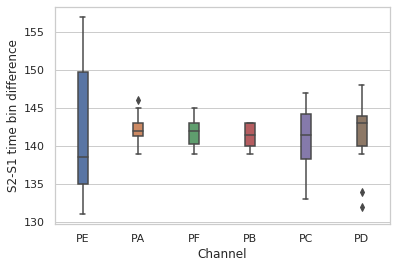

In [100]:
import seaborn as sns
import operator as op
plot_data = time_diff

# sort keys and values together
sorted_keys, sorted_vals = zip(*sorted(plot_data.items(), key=op.itemgetter(1)))

# almost verbatim from question
sns.set(context='notebook', style='whitegrid')
#sns.axlabel(xlabel="Groups", ylabel="Y-Axis", fontsize=16)
sns.boxplot(data=sorted_vals, width=.18)
#sns.swarmplot(data=sorted_vals, size=6, edgecolor="black", linewidth=.9)

# category labels
plt.xticks(plt.xticks()[0], sorted_keys)
plt.xlabel('Channel')
plt.ylabel('S2-S1 time bin difference')
plt.show()

In [101]:
time_diff['PE']

[131.0,
 150.99999999999997,
 157.00000000000003,
 135.0,
 140.0,
 135.0,
 153.99999999999997,
 136.99999999999997,
 131.00000000000003,
 146.0]

In [134]:
np.array(template[key][c])
#template[key] : per series, per channel
#proc_delay : per series, per event, per channel
#proc_of : per series, per event, per channel
proc_of[key][0]

{'PT': array([1.10895257e-05]),
 'PAS1': array([8.22910357e-07]),
 'PBS1': array([9.50206466e-07]),
 'PCS1': array([5.21427074e-07]),
 'PDS1': array([1.9588569e-06]),
 'PES1': array([6.53269783e-07]),
 'PFS1': array([8.74571039e-07]),
 'PAS2': array([7.91598058e-07]),
 'PBS2': array([1.04894216e-06]),
 'PCS2': array([6.2193087e-07]),
 'PDS2': array([1.58994004e-06]),
 'PES2': array([1.05782767e-06]),
 'PFS2': array([8.53913759e-07])}

In [169]:
# compute template for each event : time-shifted, scaled by ofamp
template_ss = {} # per series , per channel, per event
for idx, key in enumerate(series.keys()):
    t = {}
    for c in channels:
        tt = []
        for i in range(len(event_number[key])):
            shift = int((proc_delay[key][i][c]*1e6)/trace_length)
            scale = proc_of[key][i][c]
            ttt = np.array(template[key][c])
            ttt = np.roll(ttt,shift)
            ttt *= scale
            tt.append(ttt)
        t[c] = tt
    template_ss[key] = t

print('done!')


done!


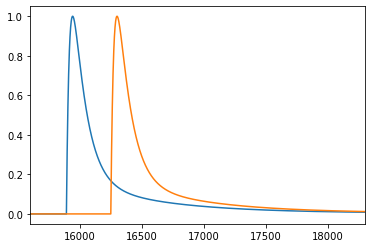

In [168]:
#plt.plot(template_ss['target']['PAS1'])
#plt.show()
plt.figure()
#template_ss['target']['PAS1'][0]
plt.plot((template_ss['target']['PAS1'][0])/np.max(template_ss['target']['PAS1'][0]))
plt.plot(template['target']['PAS1'])
plt.xlim(15600,18300)
plt.show()

In [157]:
len(template['target']['PAS1'])

32768

In [110]:
adc2uA[key]

NameError: name 'adc2uA' is not defined

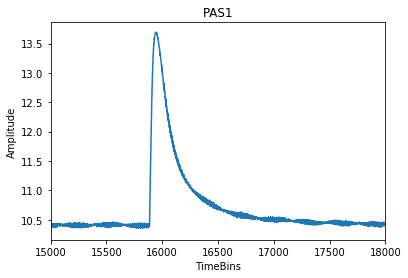

OF => amp : bs = 3.22 uA : 10.39
OFdelay = -359.000000
bs : max = 10.393235 : 13.691902
w bs subtraction = 3.298667 uA


In [113]:
c = 'PAS1'
i = 0
idx = 0
key = list(series.keys())[idx]

enum = event_number[key][i]
plt.figure()
plt.plot(data[key][c][i]*1e6)
#plt.xlim(15000,17000)
plt.xlim(15000,18000)
plt.xlabel('TimeBins')
plt.ylabel('Amplitude')
plt.title("%s"%(c))
#plt.yscale("log")
#plt.savefig('./plots/reverse_cal/selected_events/power_trace_%s_selected_noPrePulseSubtraction.png'%(c))
plt.show()
ofvalue = (OFamps[series[key]][c][EventNumber[idx] == enum])
bsvalue = (OFbs[series[key]][c][EventNumber[idx] == enum])
delayvalue = (OFdelay[series[key]][c][EventNumber[idx] == enum])
bs = np.mean(data[key][c][i][:10000])
max_ = np.max(data[key][c][i])
offset = (delayvalue*1e6)/trace_length
print('OF => amp : bs = %0.2f uA : %0.2f'%(ofvalue*1e6, (bsvalue*adc2ua[key][c])*1e6))
print('OFdelay = %f'%(offset))
print('bs : max = %f : %f'%(bs*1e6, max_*1e6))
print('w bs subtraction = %f uA'%((max_-bs)*1e6))


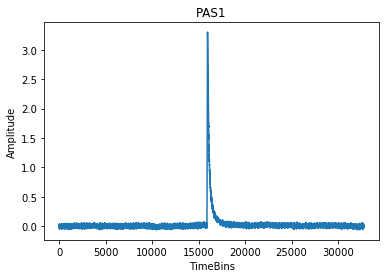

In [124]:
c = 'PAS1'
i = 0
idx = 0
key = list(series.keys())[idx]

enum = event_number[key][i]
plt.figure()
plt.plot(data_ped_sub[key][c][i]*1e6)
#plt.xlim(15000,17000)
#plt.xlim(15000,18000)
plt.xlabel('TimeBins')
plt.ylabel('Amplitude')
plt.title("%s"%(c))
#plt.yscale("log")
#plt.savefig('./plots/reverse_cal/selected_events/power_trace_%s_selected_noPrePulseSubtraction.png'%(c))
plt.show()
# ofvalue = (OFamps[series[key]][c][EventNumber[idx] == enum])
# bsvalue = (OFbs[series[key]][c][EventNumber[idx] == enum])
# delayvalue = (OFdelay[series[key]][c][EventNumber[idx] == enum])
# bs = np.mean(data[key][c][i][:10000])
# max_ = np.max(data[key][c][i])
# offset = (delayvalue*1e6)/trace_length
# print('OF => amp : bs = %0.2f uA : %0.2f'%(ofvalue*1e6, (bsvalue*adc2ua[key][c])*1e6))
# print('OFdelay = %f'%(offset))
# print('bs : max = %f : %f'%(bs*1e6, max_*1e6))
# print('w bs subtraction = %f uA'%((max_-bs)*1e6))


OF => amp : bs = 0.95 uA : 10.07
OFdelay = -218.000000
bs : max = 10.065601 : 11.061668
w bs subtraction = 0.996068 uA


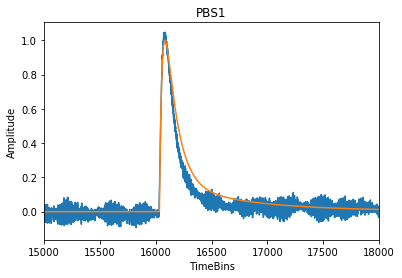

In [46]:
c = 'PBS1'
i = 1

ofvalue = (OFamps[series[key]][c][EventNumber[idx] == event_number[i]])
proc_bs = (OFbs[series[key]][c][EventNumber[idx] == event_number[i]])
proc_delay = (OFdelay[series[key]][c][EventNumber[idx] == event_number[i]])
bs = np.mean(data[c][i][:10000])
max_ = np.max(data[c][i])
offset = (proc_delay*1e6)/trace_length
print('OF => amp : bs = %0.2f uA : %0.2f'%(ofvalue*1e6, (proc_bs*ADC2uA[c])*1e6))
print('OFdelay = %f'%(offset))
print('bs : max = %f : %f'%(bs*1e6, max_*1e6))
print('w bs subtraction = %f uA'%((max_-bs)*1e6))


temp = (data[c][i]*1e6) - (proc_bs*ADC2uA[c])*1e6
temp = temp/(ofvalue*1e6)
plt.figure()
plt.plot(temp)
x = range(len(template[key][c])) + offset
y = template[key][c]
plt.plot(x,y)
#plt.xlim(15000,17000)
plt.xlim(15000,18000)
plt.xlabel('TimeBins')
plt.ylabel('Amplitude')
plt.title("%s"%(c))
#plt.yscale("log")
#plt.savefig('./plots/reverse_cal/selected_events/power_trace_%s_selected_noPrePulseSubtraction.png'%(c))
plt.show()

In [92]:
c = 'PAS1'
i = 1
event_number = EventNumber[idx][cut][:10]
psum = np.zeros(32768)

print ('channel \t OF value \t pedestal \t max (no ped sub) \t max (with ped sub) ')
for j,c in enumerate(channels):
    if(c == 'PT'):
        continue
    ofvalue = (OFamps[series[key]][c][EventNumber[idx] == event_number[i]])*1e6
    bs = (np.mean(data[c][i][:10000]))*1e6
    max_ = (np.max(data[c][i]))*1e6
    psum += data[c][i]
    print('%s \t %0.2f \t %0.2f \t %0.2f \t %0.2f'%(c, ofvalue, bs, max_, (max_ - bs)))
#     print('OF value = %f uA'%(ofvalue*1e6))
#     print('bs : max = %f : %f'%(bs*1e6, max_*1e6))
#     print('w bs subtraction = %f uA'%((max_-bs)*1e6))
ofvalue = (OFamps[series[key]]['PT'][EventNumber[idx] == event_number[i]])*1e6
bs = (np.mean(psum[:10000]))*1e6
max_ = np.max(psum)*1e6
print('PT \t %0.2f \t %0.2f \t %0.2f \t %0.2f'%(ofvalue, bs, max_, (max_ - bs)))

channel 	 OF value 	 pedestal 	 max (no ped sub) 	 max (with ped sub) 
PAS1 	 3.75 	 10.41 	 14.18 	 3.77
PBS1 	 3.87 	 10.46 	 14.58 	 4.11
PCS1 	 2.58 	 10.44 	 13.19 	 2.75
PDS1 	 4.38 	 10.43 	 14.67 	 4.24
PES1 	 4.58 	 10.49 	 14.92 	 4.43
PFS1 	 3.92 	 10.43 	 14.38 	 3.95
PAS2 	 3.91 	 10.39 	 14.28 	 3.89
PBS2 	 4.57 	 10.41 	 15.09 	 4.68
PCS2 	 3.47 	 10.43 	 14.12 	 3.69
PDS2 	 6.04 	 10.40 	 16.28 	 5.89
PES2 	 3.44 	 10.42 	 14.23 	 3.81
PFS2 	 3.98 	 10.45 	 14.71 	 4.27
PT 	 16.65 	 125.14 	 161.93 	 36.79


In [89]:
c

'T'

In [77]:
np.zeros(32768)

array([0., 0., 0., ..., 0., 0., 0.])

array([3.21722032e-06])

In [ ]:

cdms.rawio.IO.getRawEvents(rawfilepath,'/'+series[0],outputFormat = 2, eventNumbers=(event_number[c]).astype(int).tolist(), 
                                               channelList=[c])

In [39]:
cdms.rawio.IO.getRawEvents.__code__.co_varnames
#func.__code__.co_varnames

('filepath',
 'files_series',
 'eventNumbers',
 'eventIndices',
 'channelList',
 'detectorList',
 'outputFormat',
 'maxNumFiles',
 'maxNumEvents',
 'skipEmptyEvents',
 'verbose',
 'filelist',
 'fi',
 'input_str',
 'reader',
 'do_output_array',
 'events',
 'event_data_list',
 'event_num_list',
 'event_series_list',
 'ei',
 'event',
 'this_event_num',
 'this_series_num',
 'data_dict',
 'key_1',
 'key_2',
 'index_arrays',
 'df',
 'event_data_dict',
 'event_size',
 'key',
 'array_size',
 'channel_size',
 'bin_size')

In [26]:
mask = (TriggerType[0] == 1) & (OFamps[series[0]]['PT'] > 0.) & (TrigDet[0] == 6)
mask = mask & (OFamps[series[0]]['PT'] >= 1.5e-6) & (OFamps[series[0]]['PT'] <= 2e-6)
cut = mask & (OFchiq[series[0]]['PT'] >= 0.6e6) & (OFchiq[series[0]]['PT'] <= 3e6)
data = {}
raw_data = {}
det = 'Z6'
event_number = {}

In [27]:
EventNumber[0][cut]

array([ 41169.,  52968.,  91720., 101056., 110728., 121732., 131032.,
       140094., 172248., 181502., 270487., 281234., 281333., 290677.,
       301902., 310149., 331761., 341219., 370967., 371670.])

In [29]:
#c = 'PAS2'

print('Loading raw traces... ')
for c in chan:
    if(c=='PT'):
        continue
    event_number[c] = EventNumber[0][cut]
    raw_data[c] = cdms.rawio.IO.getRawEvents(rawfilepath,'/'+series[0],outputFormat = 2, eventNumbers=(event_number[c]).astype(int).tolist(), 
                                               channelList=[c])
    print('\t Done for %s'%(c))

print('Raw traces [ADC] loaded...')
print('Now converting into amps...')
for c in chan:
    if(c=='PT'):
        continue
    temp = []
    for i in range(len(raw_data[c])):
        DriverGain = dsettings[series[0]][det][c]['driverGain']*4.0 #Apply Driver Gain Correction
        conv2Amps = 1/(Rfb*DriverGain*LoopRatio*ADCperVolt) #Convert detector parameters to amplitude for trace
        temp.append(((raw_data[c][i])[det][c])*conv2Amps)
    data[c] = temp

print('Traces coverted to Amps for channel...')



Loading raw traces... 
	 Done for PAS1
	 Done for PBS1
	 Done for PCS1
	 Done for PDS1
	 Done for PES1
	 Done for PFS1
	 Done for PAS2
	 Done for PBS2
	 Done for PCS2
	 Done for PDS2
	 Done for PES2
	 Done for PFS2
Raw traces [ADC] loaded...
Now converting into amps...
Traces coverted to Amps for channel...
The file is: /sdf/group/supercdms/data/CDMS/CUTE/R37/Raw///23231217_135018/23231217_135018_F0001.mid.gz

Opened raw midas file: /sdf/group/supercdms/data/CDMS/CUTE/R37/Raw///23231217_135018/23231217_135018_F0001.mid.gz
The file is: /sdf/group/supercdms/data/CDMS/CUTE/R37/Raw///23231217_135018/23231217_135018_F0004.mid.gz

Opened raw midas file: /sdf/group/supercdms/data/CDMS/CUTE/R37/Raw///23231217_135018/23231217_135018_F0004.mid.gz
The file is: /sdf/group/supercdms/data/CDMS/CUTE/R37/Raw///23231217_135018/23231217_135018_F0005.mid.gz

Opened raw midas file: /sdf/group/supercdms/data/CDMS/CUTE/R37/Raw///23231217_135018/23231217_135018_F0005.mid.gz
The file is: /sdf/group/supercdms/

In [35]:
len(data['PAS1'])

20

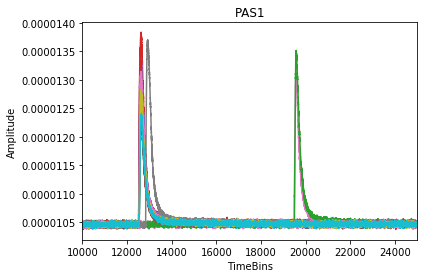

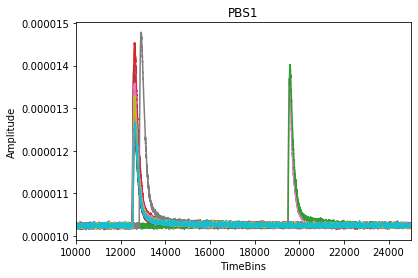

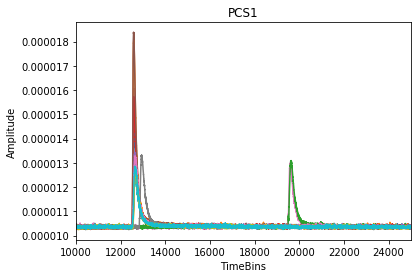

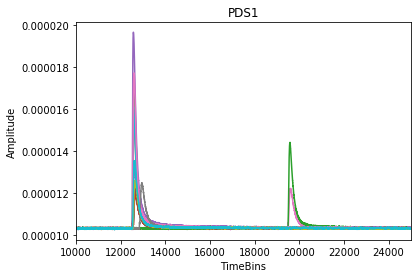

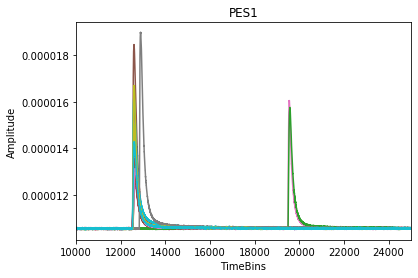

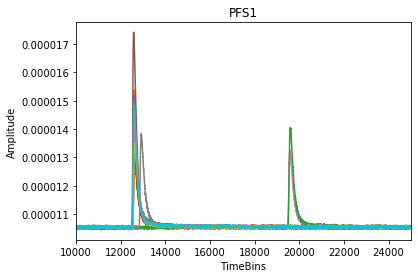

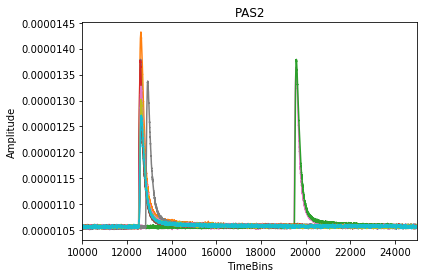

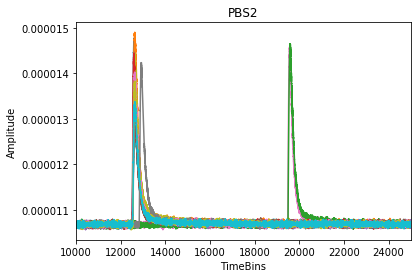

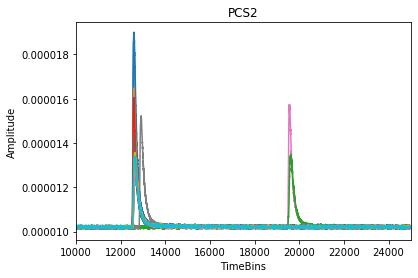

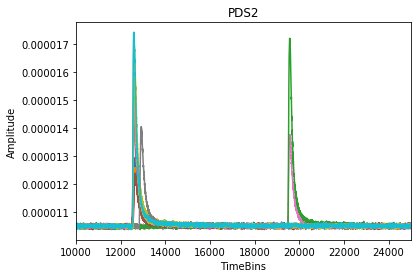

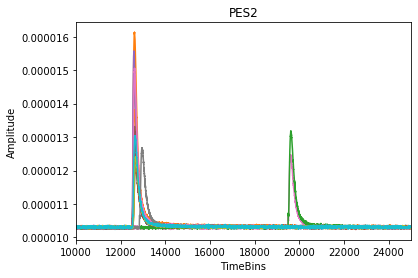

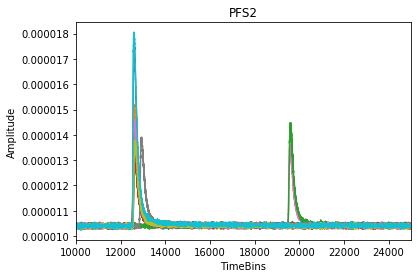

In [34]:
for c in data.keys():
    plt.figure()
    for j in np.arange(len(data[c])):
        plt.plot(data[c][j])
    #plt.xlim(15000,17000)
    plt.xlim(10000,25000)
    plt.xlabel('TimeBins')
    plt.ylabel('Amplitude')
    plt.title("%s"%(c))
    #plt.yscale("log")
    #plt.savefig('./plots/reverse_cal/selected_events/power_trace_%s_selected_noPrePulseSubtraction.png'%(c))
    plt.show()

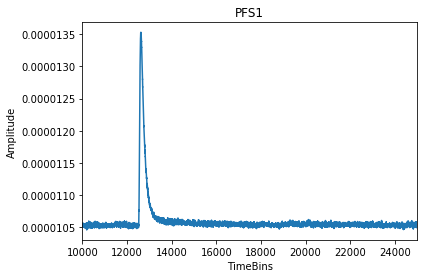

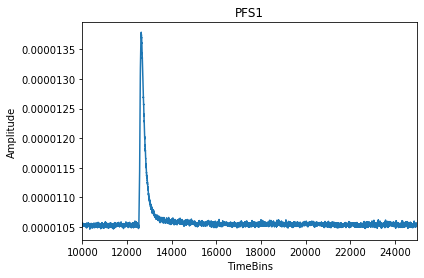

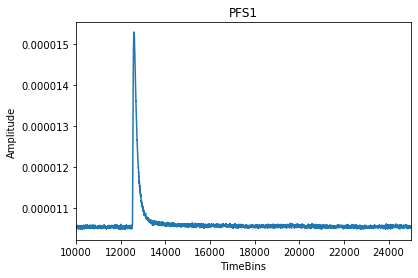

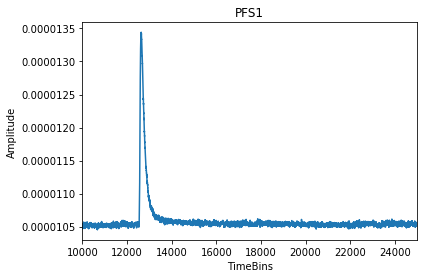

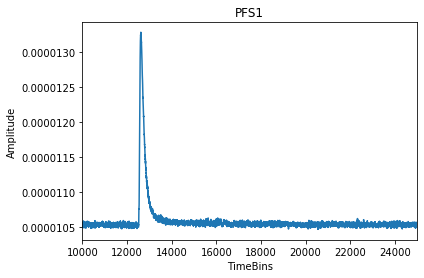

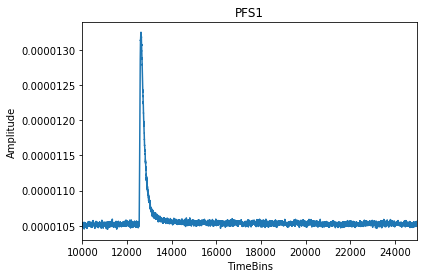

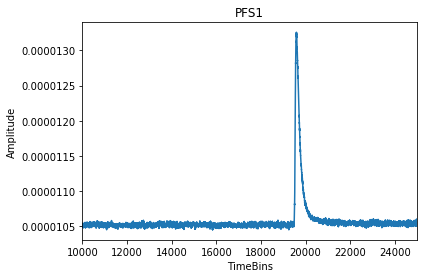

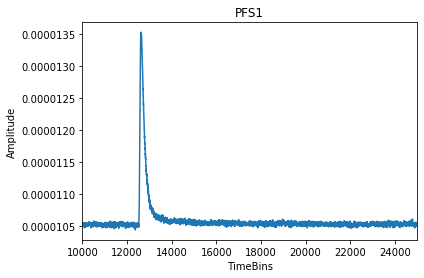

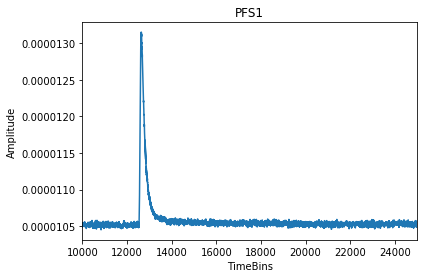

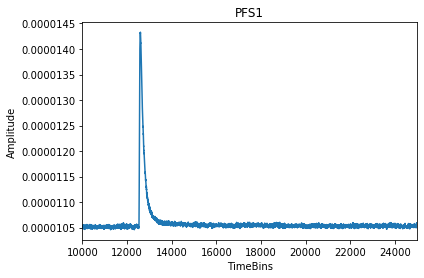

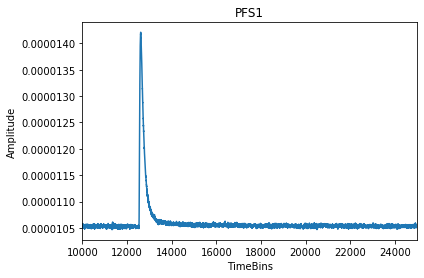

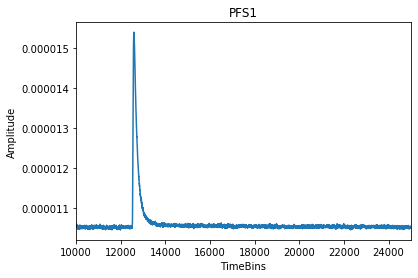

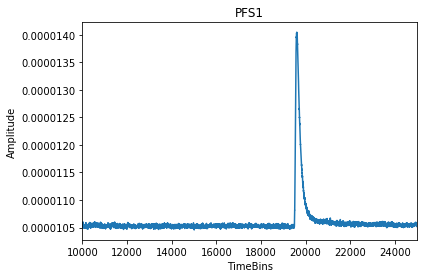

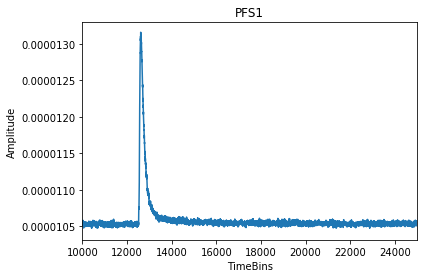

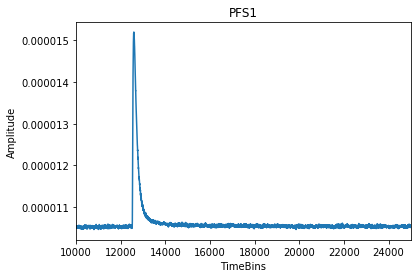

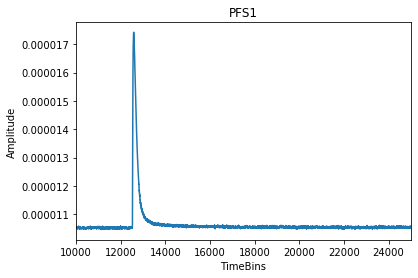

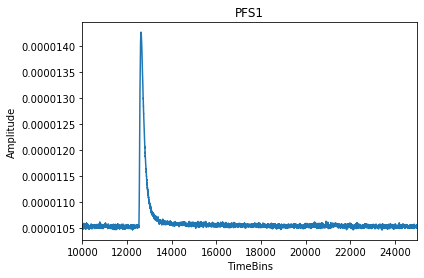

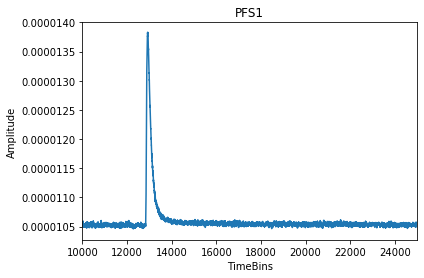

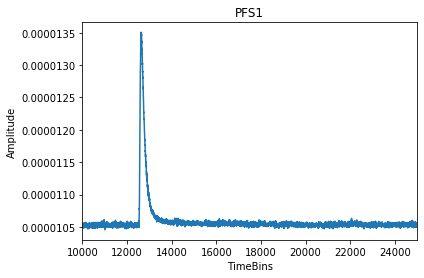

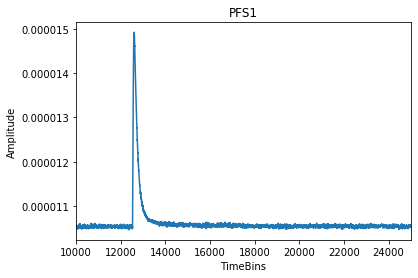

In [36]:
c = 'PFS1'
plt.figure()
for j in np.arange(len(data[c])):
    plt.plot(data[c][j])
    #plt.xlim(15000,17000)
    plt.xlim(10000,25000)
    plt.xlabel('TimeBins')
    plt.ylabel('Amplitude')
    plt.title("%s"%(c))
    #plt.yscale("log")
    #plt.savefig('./plots/reverse_cal/selected_events/power_trace_%s_selected_noPrePulseSubtraction.png'%(c))
    plt.show()

In [ ]:
raw_data[c] = cdms.rawio.IO.getRawEvents(rawfilepath,'/'+series[0],outputFormat = 2, eventNumbers=(event_number[c]).astype(int).tolist(), 
                                               channelList=[c])

In [ ]:
print('Raw traces [ADC] loaded...')
print('Now converting into amps...')

for c in chan:
    if(c=='PT'):
        continue
    temp = []
    for i in range(len(raw_data[c])):
        DriverGain = dsettings[series[0]][det][c]['driverGain']*4.0 #Apply Driver Gain Correction
        conv2Amps = 1/(Rfb*DriverGain*LoopRatio*ADCperVolt) #Convert detector parameters to amplitude for trace
        temp.append(((raw_data[c][i])[det][c])*conv2Amps)
    data[c] = temp

print('Traces coverted to Amps for channel...')

In [18]:

mask = (TriggerType[0] == 1) & (OFamps[series[0]][c] > 0.) & (OFchiq[series[0]][c] < 2e5) #new mask
cut = mask & (OFamps[series[0]]['PT'] >= 1.03e-6) & (OFamps[series[0]]['PT'] <= 2.3e-6)
data = {}
raw_data = {}
det = 'Z1'
event_number = {}

In [20]:
#c = 'PAS2'

for c in chan:
    if(c=='PT'):
        continue
    if os.path.exists('./rawdata/PT_1p05uA_2p3uA/%s_%s_selected_events.pkl'%(series[0],c)):
        raw_data[c] = pkl.load(open('./rawdata/PT_1p05uA_2p3uA/%s_%s_selected_events.pkl'%(series[0],c), "rb"))
        print('pkl file loaded for %s'%(c))
    else:
        print('No pickle file available. Loading traces... ')
        event_number[c] = EventNumber[0][cut]
        raw_data[c] = cdms.rawio.IO.getRawEvents(rawfilepath,'/'+series[0],outputFormat = 2, eventNumbers=(event_number[c]).astype(int).tolist(), 
                                               channelList=[c])
        pkl.dump(raw_data[c], open('./rawdata/PT_1p05uA_2p3uA/%s_%s_selected_events.pkl'%(series[0],c), "wb"))
        print('pkl file loaded for %s'%(c))

print('Raw traces [ADC] loaded...')
print('Now converting into amps...')
for c in chan:
    if(c=='PT'):
        continue
    temp = []
    for i in range(len(raw_data[c])):
        DriverGain = dsettings[series[0]][det][c]['driverGain']*4.0 #Apply Driver Gain Correction
        conv2Amps = 1/(Rfb*DriverGain*LoopRatio*ADCperVolt) #Convert detector parameters to amplitude for trace
        temp.append(((raw_data[c][i])[det][c])*conv2Amps)
    data[c] = temp

print('Traces coverted to Amps for channel...')



/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PAS1_selected_events.pkl'>
  import sys


pkl file loaded for PAS1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PBS1_selected_events.pkl'>
  import sys


pkl file loaded for PBS1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PCS1_selected_events.pkl'>
  import sys


pkl file loaded for PCS1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PDS1_selected_events.pkl'>
  import sys


pkl file loaded for PDS1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PES1_selected_events.pkl'>
  import sys


pkl file loaded for PES1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PFS1_selected_events.pkl'>
  import sys


pkl file loaded for PFS1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PAS2_selected_events.pkl'>
  import sys


pkl file loaded for PAS2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PBS2_selected_events.pkl'>
  import sys


pkl file loaded for PBS2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PCS2_selected_events.pkl'>
  import sys


pkl file loaded for PCS2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PDS2_selected_events.pkl'>
  import sys


pkl file loaded for PDS2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PES2_selected_events.pkl'>
  import sys


pkl file loaded for PES2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/PT_1p05uA_2p3uA/23231024_231640_PFS2_selected_events.pkl'>
  import sys


pkl file loaded for PFS2
Raw traces [ADC] loaded...
Now converting into amps...
Traces coverted to Amps for channel...


In [21]:
save = True

for c in chan:
    if(c=='PT'):
        continue
    plt.figure()
    for j in np.arange(len(data[c])):

        plt.plot(data[c][j])
        


        #plt.show()
    #plt.text(0,41.8e-6,'standard conversion',fontsize=12)
    #plt.show()
    plt.grid(b=True,which='both',axis='both')
    plt.xlabel('TimeBins')
    plt.ylabel('Current (A)')
    plt.title('%s_selected'%(c))
    if(save):
        savename='./plots/reverse_cal/selected_events/trace_%s_combined.png'%(c)
        plt.savefig(savename)
        print(savename)
    plt.close()
    #break
#     if(j ==2):
#         break

./plots/reverse_cal/selected_events/trace_PAS1_combined.png
./plots/reverse_cal/selected_events/trace_PBS1_combined.png
./plots/reverse_cal/selected_events/trace_PCS1_combined.png
./plots/reverse_cal/selected_events/trace_PDS1_combined.png
./plots/reverse_cal/selected_events/trace_PES1_combined.png
./plots/reverse_cal/selected_events/trace_PFS1_combined.png
./plots/reverse_cal/selected_events/trace_PAS2_combined.png
./plots/reverse_cal/selected_events/trace_PBS2_combined.png
./plots/reverse_cal/selected_events/trace_PCS2_combined.png
./plots/reverse_cal/selected_events/trace_PDS2_combined.png
./plots/reverse_cal/selected_events/trace_PES2_combined.png
./plots/reverse_cal/selected_events/trace_PFS2_combined.png


In [22]:
I0 = {
    'PAS1' : -24.0e-6,
    'PBS1' : -25.0e-6,
    'PCS1' : -27.5e-6,
    'PDS1' : -25.0e-6,
    'PES1' : -26.0e-6,
    'PFS1' : -27.0e-6,
    'PAS2' : -25.0e-6,
    'PBS2' : -26.5e-6,
    'PCS2' : -28.0e-6,
    'PDS2' : -26.0e-6,
    'PES2' : -27.0e-6,
    'PFS2' : -27.2e-6
}

In [23]:
converted_trace={}
for c in chan:
    if(c == 'PT'):
        continue
    temp=[]
    for i in np.arange(len(data[c])):
        temp.append((data[c][i]-DCoffset[c])*(Vbias[c]-2*I0[c]*Rl[TESs[c]]) + (Rl[TESs[c]]*(data[c][i]-DCoffset[c])**2))
        #temp.append((data[c][i]-DCoffset[c])*(Vbias[c]) + (Rl[TESs[c]]*(data[c][i]-DCoffset[c])**2))
        #temp.append(((data[c][i]-DCoffset[c])*Vbias[c])+(Rl[TESs[c]]*(data[c][i]-DCoffset[c])**2))
        #temp.append(((data[c][i]-DCoffset[c])*QETbias[c]*Rshunt)+(Rl*(data_Al[s][i]-DCoffset[s])**2))
    converted_trace[c]=temp
    print('Trace converted for channel = ',c)

Trace converted for channel =  PAS1
Trace converted for channel =  PBS1
Trace converted for channel =  PCS1
Trace converted for channel =  PDS1
Trace converted for channel =  PES1
Trace converted for channel =  PFS1
Trace converted for channel =  PAS2
Trace converted for channel =  PBS2
Trace converted for channel =  PCS2
Trace converted for channel =  PDS2
Trace converted for channel =  PES2
Trace converted for channel =  PFS2


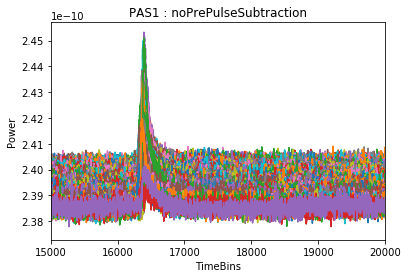

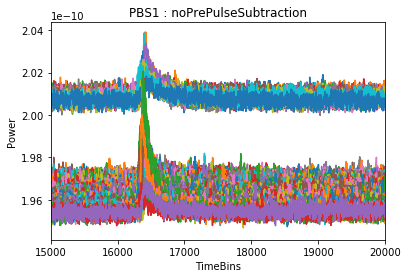

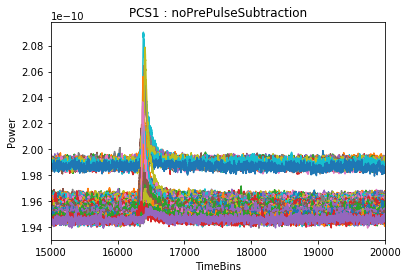

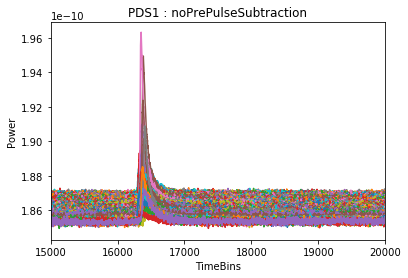

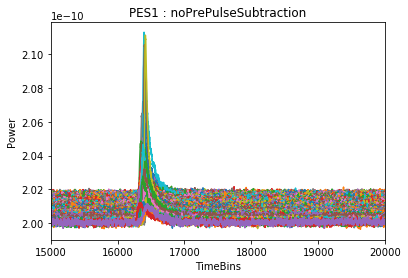

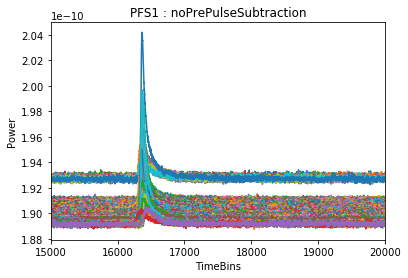

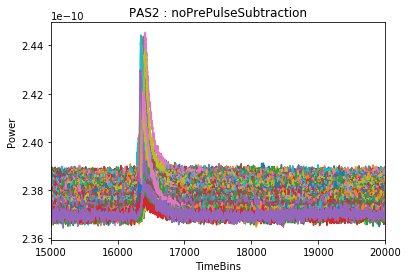

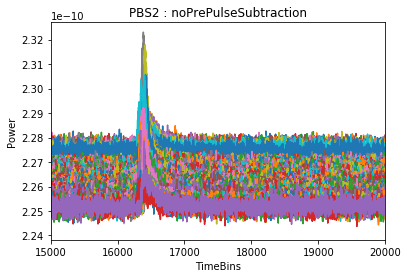

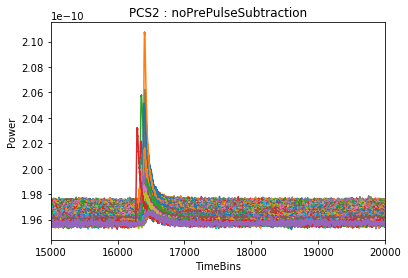

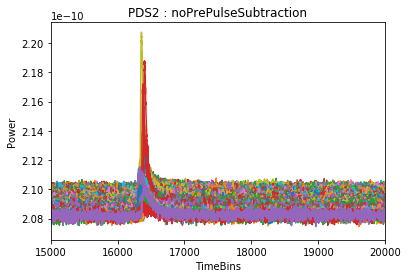

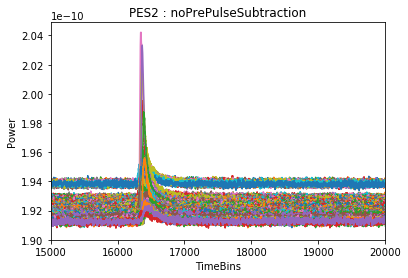

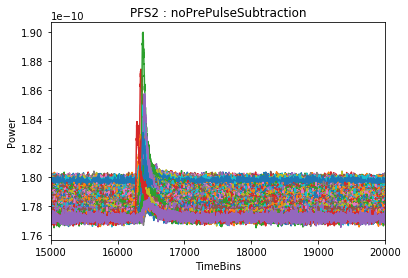

In [25]:
for c in data.keys():
    plt.figure()
    for j in np.arange(len(converted_trace[c])):
        plt.plot(converted_trace[c][j])
    #plt.xlim(15000,17000)
    plt.xlim(15000,20000)
    plt.xlabel('TimeBins')
    plt.ylabel('Power')
    plt.title("%s : noPrePulseSubtraction"%(c))
    plt.savefig('./plots/reverse_cal/selected_events/power_trace_%s_selected_noPrePulseSubtraction.png'%(c))
    plt.show()

In [26]:
prepulse={}
for c in data.keys():
    temp=[]
    for i in np.arange(len(data[c])):
        temp.append(np.mean(converted_trace[c][i][:15000]))
    prepulse[c]=temp
print('Done!')

Done!


In [27]:
converted_trace_shifted={}
for c in data.keys():
    temp=[]
    for i in np.arange(len(converted_trace[c])):
        temp.append(converted_trace[c][i]-prepulse[c][i])
    converted_trace_shifted[c]=temp
print('Done!')

Done!


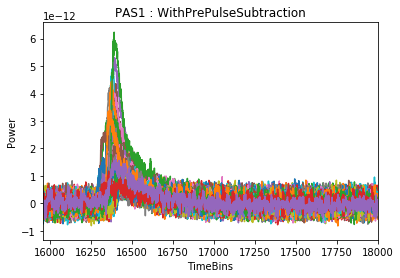

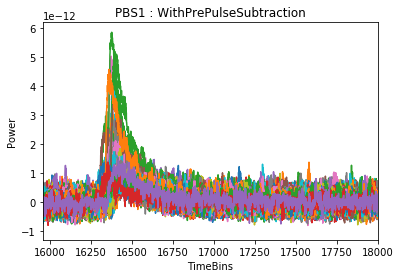

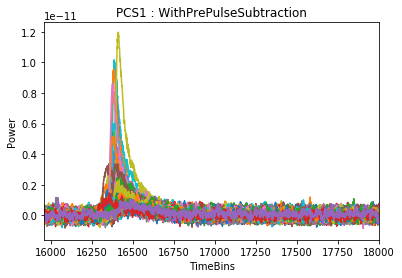

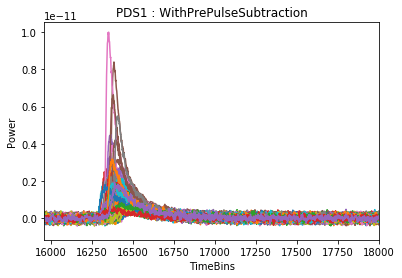

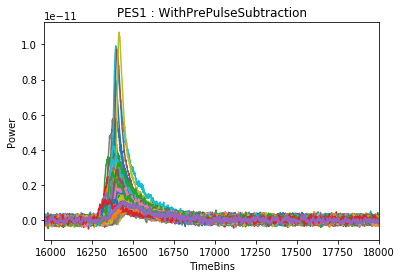

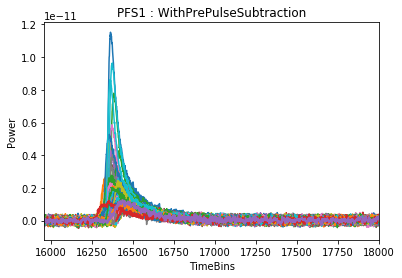

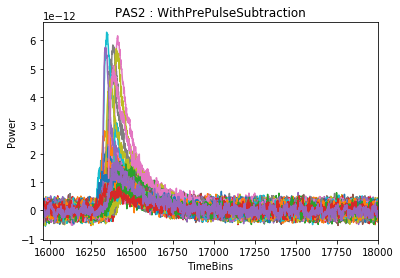

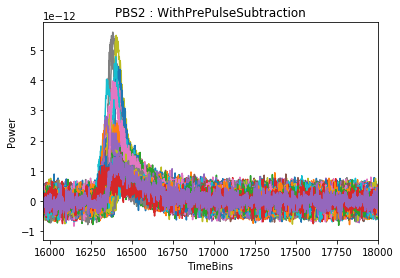

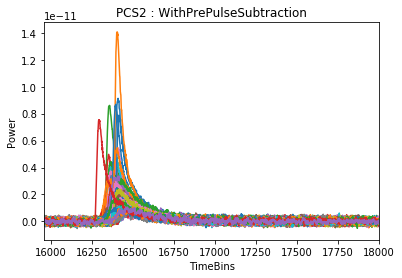

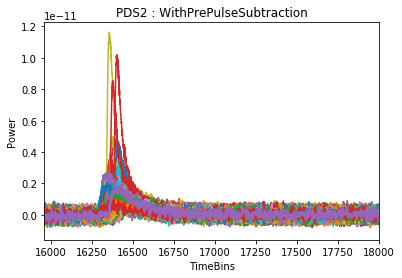

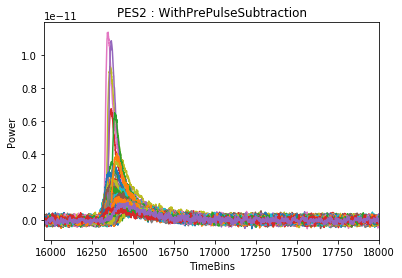

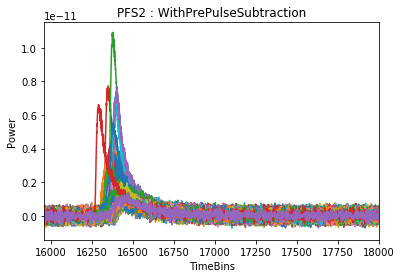

In [29]:
for c in data.keys():
    plt.figure()
    for j in np.arange(len(converted_trace_shifted[c])):
        plt.plot(converted_trace_shifted[c][j])
    #plt.xlim(15000,17000)
    #plt.vlines(16275,0,2.5e-11)
    plt.xlim(15960,18000)
    plt.xlabel('TimeBins')
    plt.ylabel('Power')
    plt.title("%s : WithPrePulseSubtraction"%(c))
    plt.savefig('./plots/reverse_cal/selected_events/power_trace_%s_selected_WithPrePulseSubtraction.png'%(c))
    plt.show()

In [125]:
len(converted_trace_shifted['PAS1'][0])

32768

In [30]:
#Calculating integrated energy using trapezoidal integral. You can also use np.trapz for this instead of writing the innermost for loop
Integrated_energy={}
#nFT=20
#FT=93.4e-6
for c in data.keys():
    temp=[]
    for i in np.arange(len(converted_trace_shifted[c])):
        numsum=0
        for j in np.arange(15960,18000):
            numsum=numsum+0.5*(converted_trace_shifted[c][i][j]+converted_trace_shifted[c][i][j+1])*1.6*1e-6
        temp.append(numsum/(1.602*1e-19*1e3))
    Integrated_energy[c]=temp
print('Done!')

Done!


In [31]:
Integrated_energy['PAS1']

[3.802368922873959,
 5.98385725633412,
 3.139485200698989,
 2.0935427937791022,
 2.482830942075831,
 2.1267516200563352,
 3.471626885707466,
 2.8057850932473603,
 4.592151935521732,
 2.0816196543845074,
 5.190294088255974,
 2.9746153001468594,
 1.7235546925088465,
 3.226173159322163,
 4.930745485935268,
 1.2071234937987152,
 4.347245665512358,
 1.593966154679187,
 4.292932857498578,
 4.252049376187774,
 2.1331269684342127,
 1.669791344422978,
 1.6957528173817635,
 4.078318720821279,
 3.110598005809203,
 3.5670322222081428,
 4.078023486998589,
 3.4550608778846517,
 2.390562564526938,
 3.98521031651459,
 2.6852800388293696,
 3.9813321644798725,
 3.5378086282386336,
 2.7322573400837236,
 7.374641610970908,
 2.570579878610354,
 2.172298213910874,
 3.1483055454762834,
 2.608088552833234,
 5.222353517812026,
 3.097604745587929,
 2.392483143576855,
 3.324538842264518,
 3.3129282228145085,
 4.4407951628926785,
 5.559319127870889,
 2.382495197231437,
 3.431310928454842,
 0.9183795517253541,
 2.

In [32]:
Integrated_energy_net={}
for c in data.keys():
    temp = []
    for j in np.arange(len(Integrated_energy[c])):
        temp.append(Integrated_energy[c][j])
    Integrated_energy_net[c] = temp
print('Done!')

Done!


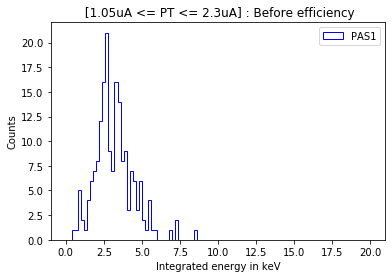

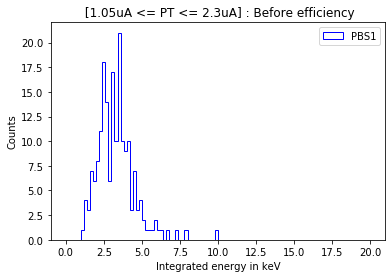

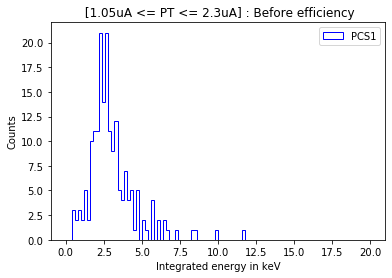

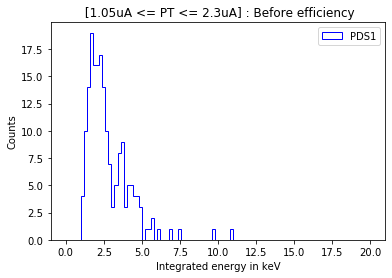

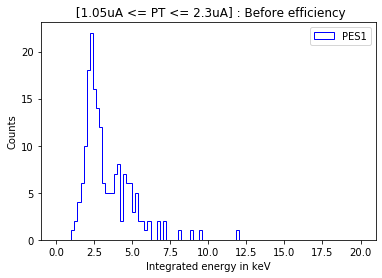

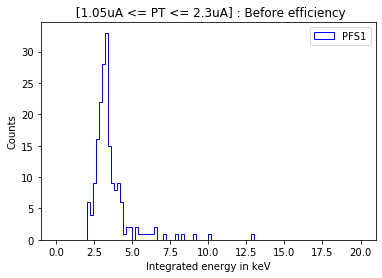

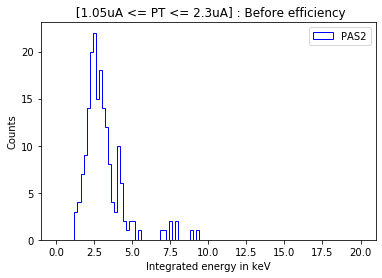

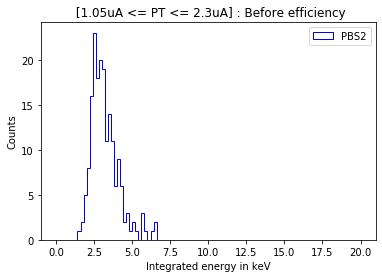

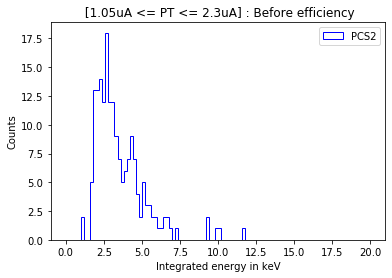

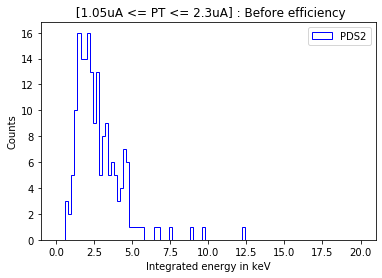

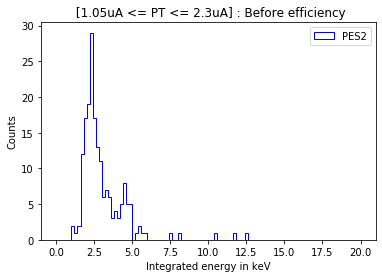

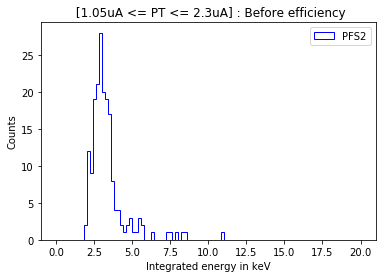

In [34]:
for c in data.keys():
    plt.hist(Integrated_energy_net[c],bins=100,histtype="step", range=[0,20], density=False, color='b', label='%s'%(c))
    plt.xlabel('Integrated energy in keV')
    plt.legend()
    plt.title(' [1.05uA <= PT <= 2.3uA] : Before efficiency')
    plt.ylabel('Counts')
    plt.savefig('./plots/reverse_cal/selected_events/integrated_energy_%s_before_eff.png'%(c))
    #plt.yscale("log")
    plt.show()

In [35]:

h_intE = []

for c in chan:
    if(c=='PT'):
        continue
    hname = 'h_intE_%s'%(c)
    temp = rt.TH1F(hname,hname,75,0,15)
    h_intE.append(temp)

In [36]:
for i,c in enumerate(chan):
    if(c=='PT'):
        continue
    for en in Integrated_energy_net[c]:
        h_intE[i-1].Fill(en)
    print('Done for %s'%(c))

Done for PAS1
Done for PBS1
Done for PCS1
Done for PDS1
Done for PES1
Done for PFS1
Done for PAS2
Done for PBS2
Done for PCS2
Done for PDS2
Done for PES2
Done for PFS2


In [37]:
gaus = []
means = {}
for i,c in enumerate(chan):
    if(c=='PT'):
        continue
    j = i-1
    mean = h_intE[j].GetMean()
    rms = h_intE[j].GetRMS()
    fit_range = [mean - 1.5*rms, mean + 1.5*rms]
    gaus.append(rt.TF1('gaus_%s'%(c),'gaus(0)',fit_range[0],fit_range[1]))
    gaus[j].SetParameters(10, mean, rms)
    h_intE[j].Fit(gaus[j],'Q','',fit_range[0],fit_range[1])
    gaus[j] = h_intE[j].GetFunction('gaus_%s'%(c))
    mean = gaus[j].GetParameter(1)
    rms = gaus[j].GetParameter(2)
    fit_range = [mean - 1.5*rms, mean + 1.5*rms]
    h_intE[j].Fit(gaus[j],'Q','',fit_range[0],fit_range[1])
    gaus[j] = h_intE[j].GetFunction('gaus_%s'%(c))
    mean = gaus[j].GetParameter(1)
    means[c] = mean

print('Done')

Done


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [38]:
for i,c in enumerate(chan):
    if(c=='PT'):
        continue
    j = i-1
    print('%s =  Mean : efficiency :: %0.2f : %0.2f'%(c, means[c],(means[c]/10.37)*100))

PAS1 =  Mean : efficiency :: 2.83 : 27.33
PBS1 =  Mean : efficiency :: 3.03 : 29.19
PCS1 =  Mean : efficiency :: 2.59 : 25.01
PDS1 =  Mean : efficiency :: 2.08 : 20.03
PES1 =  Mean : efficiency :: 2.52 : 24.29
PFS1 =  Mean : efficiency :: 3.13 : 30.18
PAS2 =  Mean : efficiency :: 2.61 : 25.21
PBS2 =  Mean : efficiency :: 2.88 : 27.73
PCS2 =  Mean : efficiency :: 2.81 : 27.06
PDS2 =  Mean : efficiency :: 2.27 : 21.90
PES2 =  Mean : efficiency :: 2.25 : 21.74
PFS2 =  Mean : efficiency :: 2.96 : 28.57


Info in <TCanvas::Print>: png file ./plots/fitted/PAS1.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PBS1.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PCS1.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PDS1.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PES1.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PFS1.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PAS2.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PBS2.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PCS2.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PDS2.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PES2.png has been created
Info in <TCanvas::Print>: png file ./plots/fitted/PFS2.png has been created


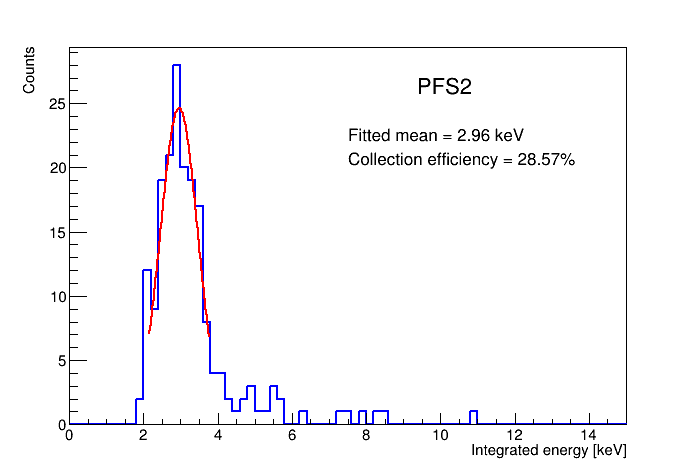

In [39]:
for i in range(12):
    can=rt.TCanvas()
    rt.gStyle.SetOptStat(0)
    c = chan[i+1]
    h_intE[i].SetName('%s'%(c))
    h_intE[i].GetXaxis().SetTitle('Integrated energy [keV]')
    h_intE[i].GetYaxis().SetTitle('Counts')
    h_intE[i].SetTitle('')
    h_intE[i].SetLineColor(rt.kBlue)
    h_intE[i].SetLineWidth(2)
    h_intE[i].Draw()
    textOnTop = rt.TLatex()
    textOnTop.SetTextSize(0.05)
    textOnTop.DrawLatexNDC(0.6,0.8,'#bf{%s}'%(c))
    textOnTop.SetTextSize(0.04)
    textOnTop.DrawLatexNDC(0.5,0.7,'#bf{Fitted mean = %0.2f keV}'%(means[c]))
    textOnTop.DrawLatexNDC(0.5,0.65,'#bf{Collection efficiency = %0.2f%%}'%((means[c]/10.37)*100))
    can.Draw()
    can.SaveAs('./plots/fitted/%s.png'%(c))
    #break